<a href="https://colab.research.google.com/github/HanifRafandi014/3D_Jobsheet_PCVK_Sem5/blob/master/PCVK_Kuis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# **Tahap Pre Processing**

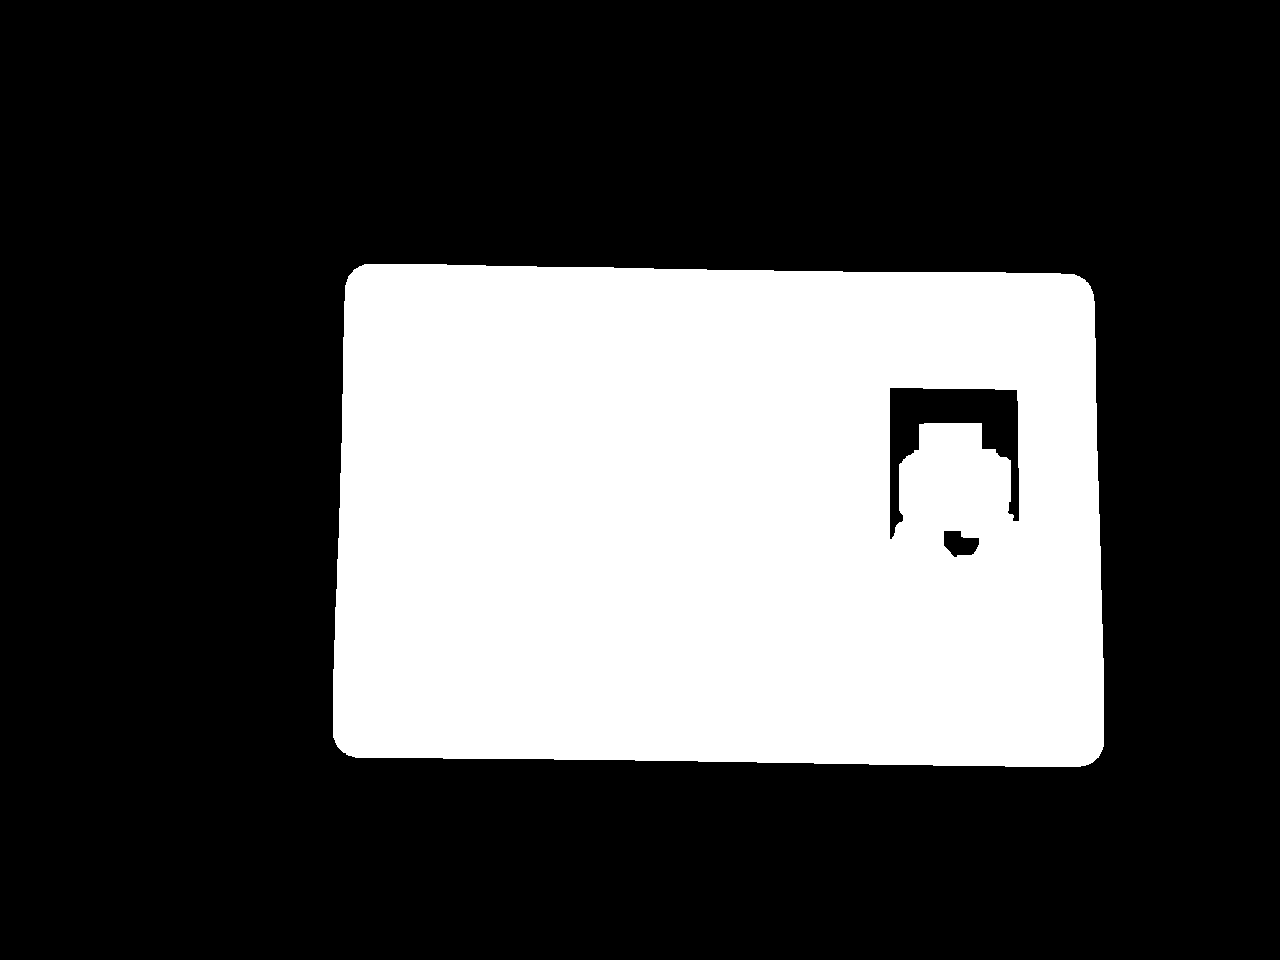

In [ ]:
# Tahap Pre Processing
img = cv2.imread('/content/drive/MyDrive/File PCVK/dataset_kuis2/ktp7.jpg')
img_original = np.copy(img)

# Apply Gaussian Blur
blurred_img = cv2.GaussianBlur(img_original, (5, 5), 0.5)

# Apply Erosion
kernel_erosion = np.ones((3, 3), np.uint8)
eroded_img = cv2.erode(blurred_img, kernel_erosion, iterations=1)

# Apply Dilation
kernel_dilation = np.ones((5, 5), np.uint8)
dilated_img = cv2.dilate(eroded_img, kernel_dilation, iterations=10)

# Apply Opening (Erosion followed by Dilation)
kernel_opening = np.ones((5, 5), np.uint8)
opening_img = cv2.morphologyEx(dilated_img, cv2.MORPH_OPEN, kernel_opening)

gray = cv2.cvtColor(opening_img, cv2.COLOR_BGR2GRAY)

# Otsu Thresholding
_, otsu_thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2_imshow(otsu_thresholded)

# **Tahap Lokalisasi**

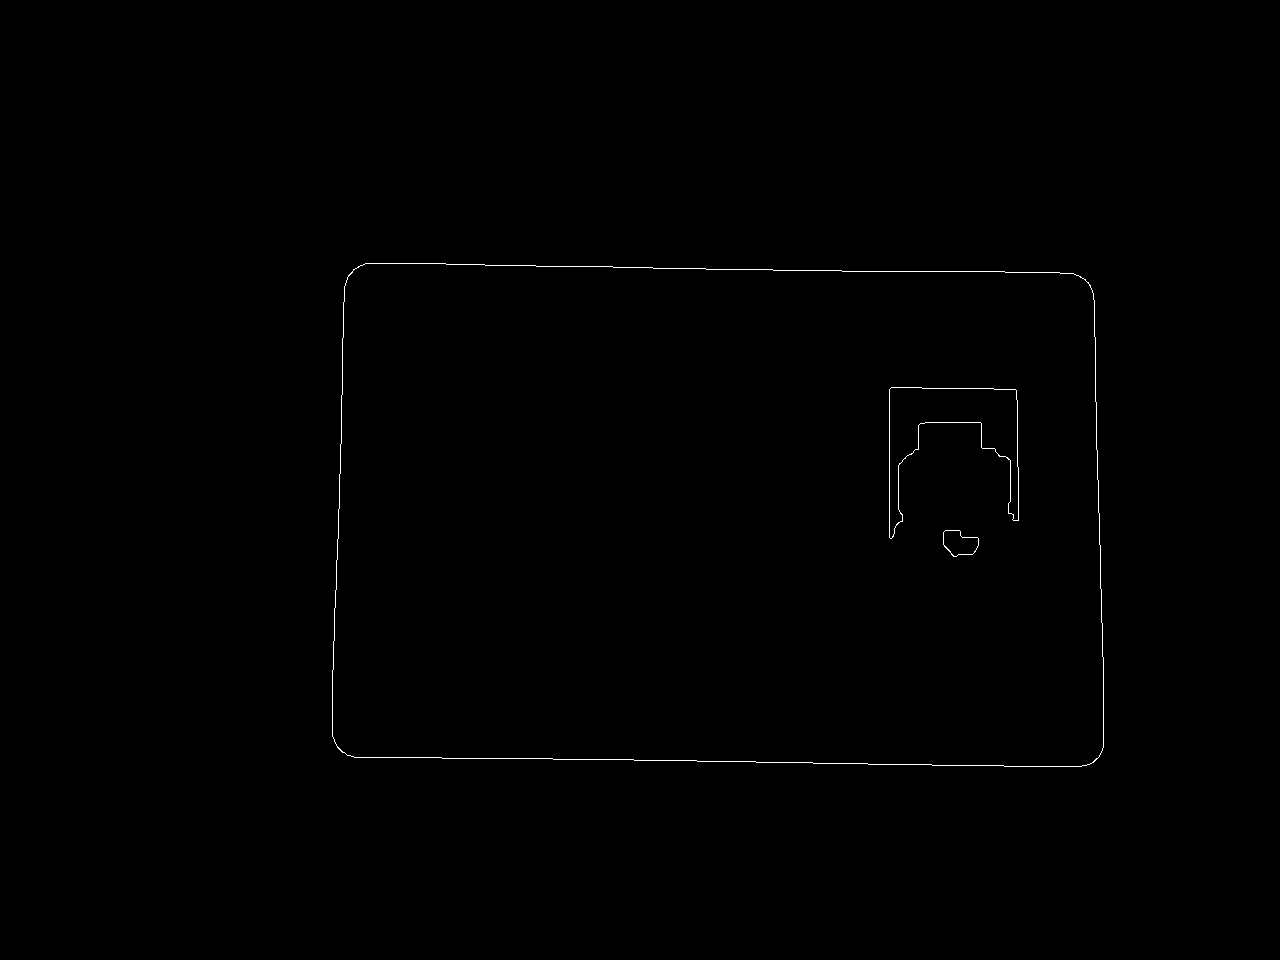

In [ ]:
# Lokalisasi (Canny)
edged = cv2.Canny(otsu_thresholded, 50, 150)
cv2_imshow(edged)

# **Tahap Segmentasi**

In [ ]:
# Segmentasi
def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.015 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
biggest = biggest_contour(contours)
cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)

# Bitwise AND operation
mask = np.zeros_like(edged)
cv2.drawContours(mask, [biggest], -1, 255, thickness=cv2.FILLED)
segmented = cv2.bitwise_and(img, img, mask=mask)

# Warp Prespective
points = biggest.reshape(4, 2)
input_points = np.zeros((4, 2), dtype="float32")

points_sum = points.sum(axis=1)
input_points[0] = points[np.argmin(points_sum)]
input_points[3] = points[np.argmax(points_sum)]

points_diff = np.diff(points, axis=1)
input_points[1] = points[np.argmin(points_diff)]
input_points[2] = points[np.argmax(points_diff)]

(top_left, top_right, bottom_right, bottom_left) = input_points
bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

# **Hasil Output Gambar**

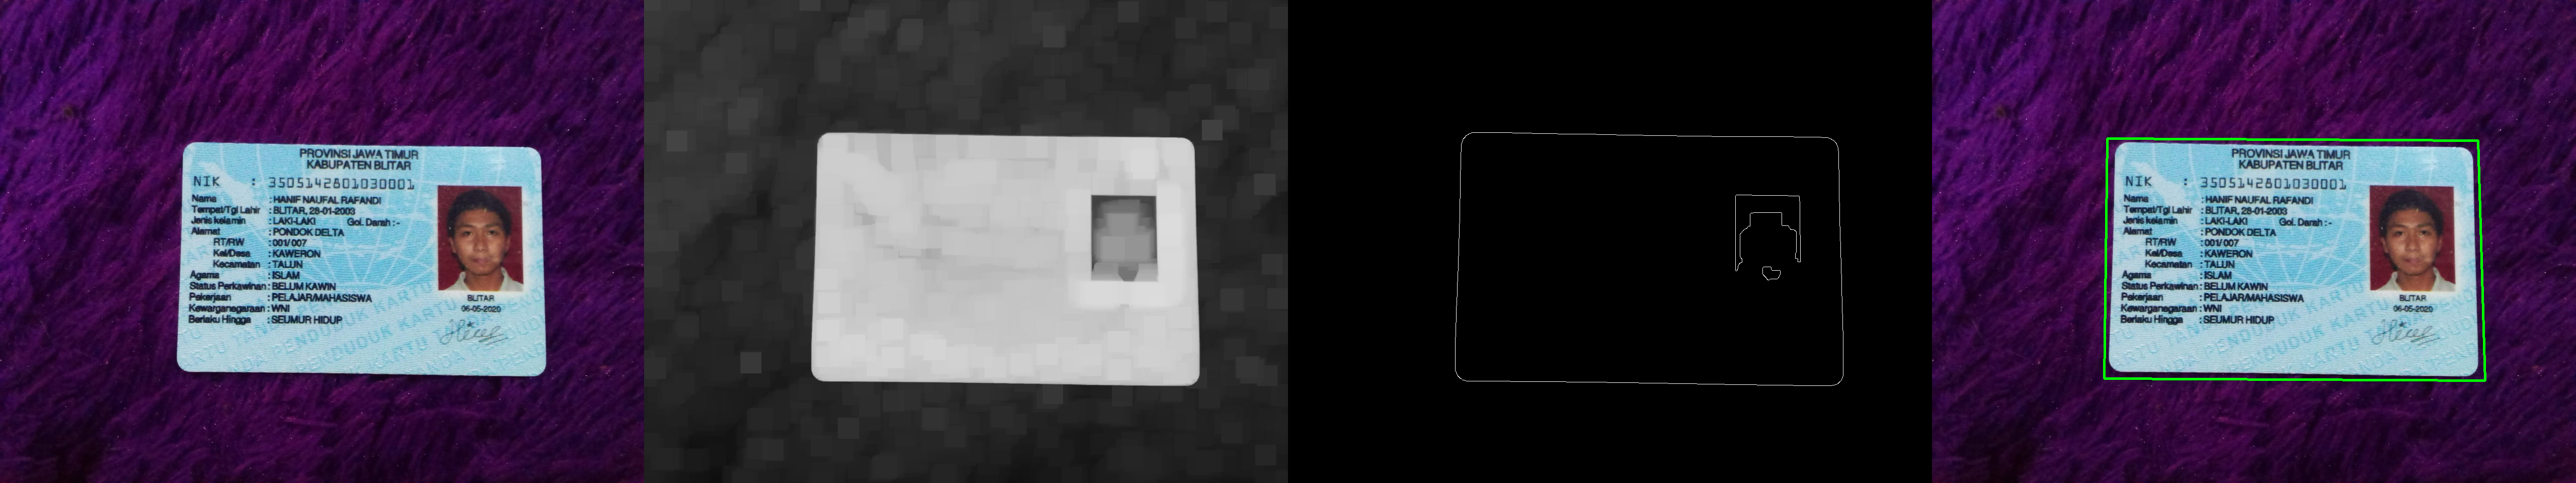

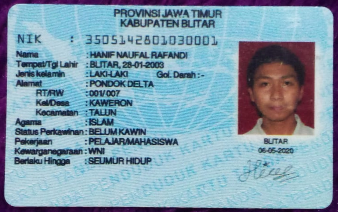

In [ ]:
# Output gambar setelah Warp Prespective
ktp_width = 8.6  # Lebar KTP dalam cm
ktp_height = 5.4  # Tinggi KTP dalam cm

max_width = int(ktp_width * 100 / 2.54)
max_height = int(ktp_height * 100 / 2.54)

# Desired points values in the output image
converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

# Perspective transformation
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

# Image shape modification for hstack
gray = np.stack((gray,) * 3, axis=-1)
edged = np.stack((edged,) * 3, axis=-1)

img_hor = np.hstack((img_original, gray, edged, img))
cv2_imshow(img_hor)
cv2_imshow(img_output)

# **Tahap Sharpening (Pre Processing)**

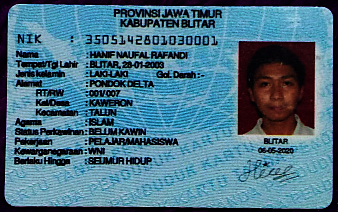

In [ ]:
# Tahap Sharpening
def gamma_correction(image, gamma):
    inv_gamma = 1 / gamma
    gamma_image = np.clip((image / 255) ** inv_gamma * 255, 0, 255).astype(np.uint8)
    return gamma_image

def convolution2d(image, kernel):
    return cv2.filter2D(image, -1, kernel)

kernel_sharpen = np.array([[1, 4, 6, 4, 1],
                                [4, 16, 24, 16, 4],
                                [6, 24, -476, 24, 6],
                                [4, 16, 24, 16, 4],
                                [1, 4, 6, 4, 1]], dtype=np.float32) * -1 / 256

result = np.copy(img_output)
ktp_result = gamma_correction(result, 0.5)
ktp_filtered = convolution2d(ktp_result, kernel_sharpen)

cv2_imshow(ktp_filtered)

# **Tahap Deteksi Wajah (Cascade)**

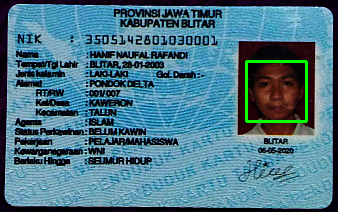

In [ ]:
# Tahap Deteksi
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/File PCVK/haarcascades/haarcascade_frontalface_alt.xml')
detect = np.copy(ktp_filtered)
gray = cv2.cvtColor(detect, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(20, 20))

for (x, y, w, h) in faces:
    cv2.rectangle(detect, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2_imshow(detect)

# **Pengenalan KTP Image to Text**

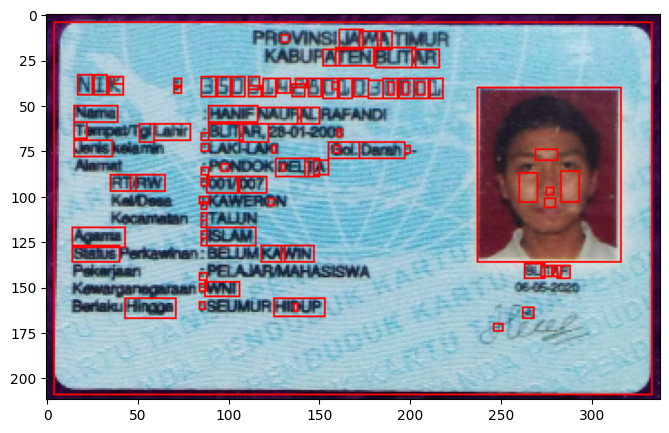

In [ ]:
import os

# load data
img_ktp = np.copy(img_output)
blurred = cv2.GaussianBlur(img_ktp, (5, 5), 0.2)

gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
ret, bw = cv2.threshold(gray.copy(), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

erode = cv2.erode(bw.copy(), cv2.getStructuringElement(cv2.MORPH_OPEN, (1, 1)))

# Ekstraksi kontur
contours, hierarchy = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# Looping contours untuk mendapatkan kontur yang sesuai
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    ras = format(w / h, '.2f')
    if h >= 4 and w >= 2 and float(ras) <= 3:
      cv2.rectangle(img_ktp, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img_ktp, cv2.COLOR_BGR2RGB))

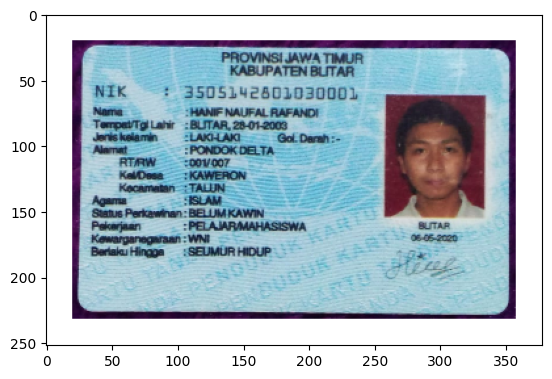

In [ ]:
ktp = np.copy(img_output)
ktp = cv2.copyMakeBorder(
	src=ktp,
	top=20,
	bottom=20,
	left=20,
	right=20,
	borderType=cv2.BORDER_CONSTANT,
	value=(255, 255, 255))
plt.imshow(cv2.cvtColor(ktp, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.show()

# **Pengambilan NIK untuk Pengenalan Karakter**

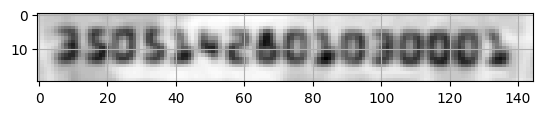

In [ ]:
ktp_gray = cv2.cvtColor(ktp, cv2.COLOR_BGR2GRAY)
ktp_blur = cv2.GaussianBlur(
                src=ktp_gray,
                ksize=(5, 5),
                sigmaX=0,
                sigmaY=0)
ktp_crop = ktp_blur[50:70, 100:245]
plt.imshow(ktp_crop, cmap='gray')
plt.grid(True)
plt.show()

# **Output Pengenalan Karaktek NIK**

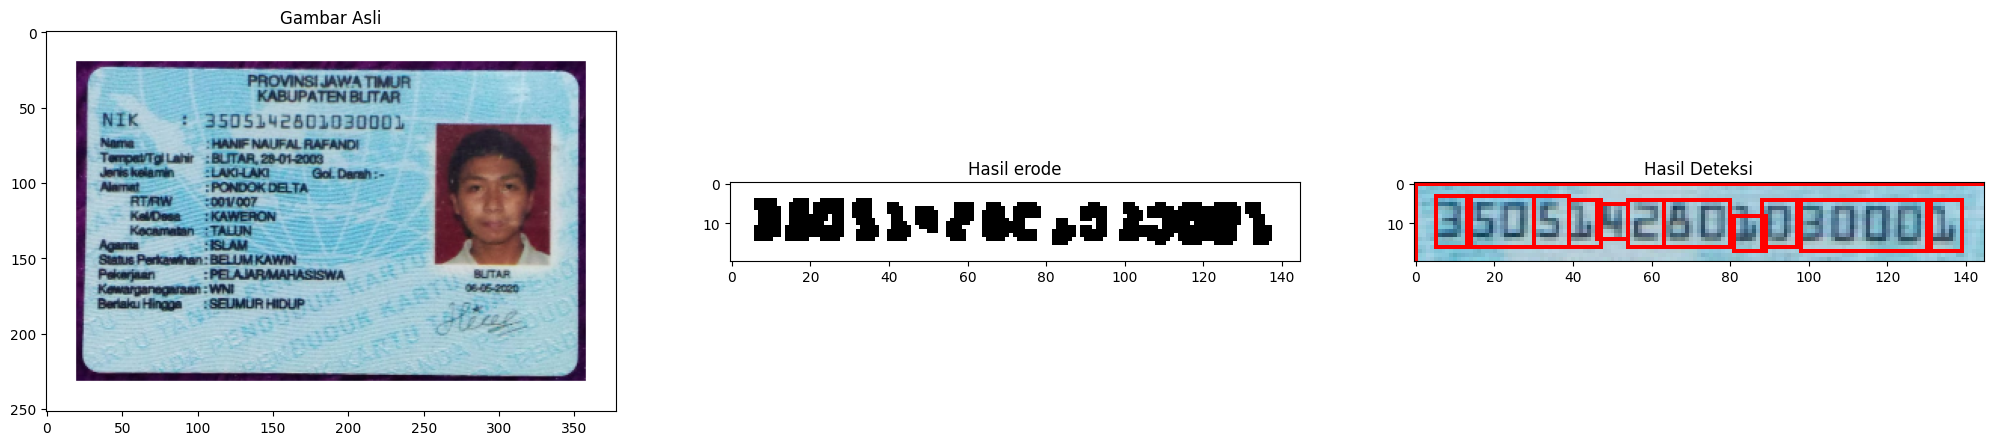

In [ ]:
output = ktp[50:70, 100:245].copy()
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(5,5))
gray = clahe.apply(ktp_crop)
ret, bw = cv2.threshold(gray.copy(), 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# make more clear using closing
kernel = np.ones((3,3), np.uint8)
closing = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=1)
dilate = closing.copy()



# Ekstraksi kontur
contours, hierarchy = cv2.findContours(dilate.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# Looping contours untuk mendapatkan kontur yang sesuai
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    ras = format(w / h, '.2f')
    if h >= 40 and w >= 10 and float(ras) <= 1:
      cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
    elif h >= 8 and w >= 8 and float(ras) <= 10:
      cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
    elif h >= 10 and w >= 7 and float(ras) <= 8:
      cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)

      # cv.drawContours(ktp, contours, -1, (0, 255, 0), 2)

# Menampilkan gambar KTP dengan kontur menggunakan plt
f, axarr = plt.subplots(1, 3, figsize=(25, 8))
axarr[0].imshow(cv2.cvtColor(ktp, cv2.COLOR_BGR2RGB))
axarr[0].set_title("Gambar Asli")
axarr[1].imshow(dilate, cmap='gray')
axarr[1].set_title("Hasil erode")
axarr[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axarr[2].set_title("Hasil Deteksi")
plt.show()